# Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import svm, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import LinearSVR
from sklearn.linear_model import Lasso, Ridge

# Data

In [2]:
df = pd.DataFrame(np.load(r'../data/master_prepared.npy', allow_pickle=True))
cols = np.load(r'../data/columns_prepared.npy', allow_pickle=True)
df.columns = cols

In [3]:
drop_cols = [
    'date',
    'eligible',
    'companyid', 
    'ret_1f1',
    'ret_1f3',
    'ret_1f6',
    'ret_1f12',
    'retxs_1f1',
    'retxs_1f3',
    'retxs_1f6',
    'retxs_1f12'
]

y_col = 'ret_1f1'

# X cols are the independent variables
x_cols = [i for i in list(df.columns) if i not in drop_cols]

# Only use eligible data
df_eligible = df[df['eligible']==1]
X = df_eligible[x_cols].astype('float64')
y = df_eligible[y_col].astype('float64')

In [4]:
def prepare_data(start_index, train_range):

    # Dates
    global dates
    dates = df['date'].unique()
    train_dates = dates[start_index:start_index+train_range+1]
    test_dates = dates[start_index+train_range+1]

    # Training Data
    X_train = X[df_eligible['date'].isin(train_dates)].astype('float64')
    X_train = sm.add_constant(X_train)
    y_train = y[df_eligible['date'].isin(train_dates)].astype('float64')

    # Test Data
    X_test = X[df_eligible['date']==test_dates].astype('float64')
    X_test.insert(0, 'const', 1)
    y_test = y[df_eligible['date']==test_dates].astype('float64')
        
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = prepare_data(60, 36)

# Models

In [5]:

predictor_sets = {
    'FF3':
    [
        'mv',
        'bvtmv',
        'beta'
    ],
    'FF3*':
    [
        'mv',
        'mv_^2',
        'mv_^3',
        'bvtmv',
        'bvtmv_^2',
        'bvtmv_^3',
        'beta',
        'beta_^2',
        'beta_^3',
    ],
    'FF3_':
    [
        'MKT',
        'SMB',
        'HML'
    ],
    'FF3_*':
    [
        'MKT',
        'MKT_^2',
        'MKT_^3',
        'SMB',
        'SMB_^2',
        'SMB_^3',
        'HML',
        'HML_^2',
        'HML_^3'
    ],
    'FF5':
    [
        'mv',
        'bvtmv',
        'beta',
        'opmarg',
        'roic'
    ],
    'FF5*':
    [
        'mv',
        'mv_^2',
        'mv_^3',
        'bvtmv',
        'bvtmv_^2',
        'bvtmv_^3',
        'beta',
        'beta_^2',
        'beta_^3',
        'opmarg',
        'opmarg_^2',
        'opmarg_^3',
        'roic',
        'roic_^2',
        'roic_^3'
    ],
    'FF5_':
    [
        'MKT',
        'SMB',
        'HML',
        'RMW',
        'CMA'
    ],
    'FF5_*':
    [
        'MKT',
        'MKT_^2',
        'MKT_^3',
        'SMB',
        'SMB_^2',
        'SMB_^3',
        'HML',
        'HML_^2',
        'HML_^3',
        'RMW',
        'RMW_^2',
        'RMW_^3',
        'CMA',
        'CMA_^2',
        'CMA_^3',
    ],
    'vol':
    [
        'mv',
        'bvtmv',
        'beta',
        'std_3m',
        'std_6m',
        'std_12m',
        'std_24m',
    ],
    'vol*':
    [
        'mv',
        'mv_^2',
        'mv_^3',
        'bvtmv',
        'bvtmv_^2',
        'bvtmv_^3',
        'beta',
        'beta_^2',
        'beta_^3',
        'std_3m',
        'std_3m_^2',
        'std_3m_^3',
        'std_6m',
        'std_6m_^2',
        'std_6m_^3',
        'std_12m',
        'std_12m_^2',
        'std_12m_^3',
        'std_24m',
        'std_24m_^2',
        'std_24m_^3'
    ],
    'vol_':
    [
        'MKT',
        'SMB',
        'HML',
        'VOL'
    ],
    'vol_*':
    [
        'MKT',
        'MKT_^2',
        'MKT_^3',
        'SMB',
        'SMB_^2',
        'SMB_^3',
        'HML',
        'HML_^2',
        'HML_^3',
        'VOL',
        'VOL_^2',
        'VOL_^3'
    ],
    'mom':
    [
        'mv',
        'bvtmv',
        'beta',
        'ret_3m',
        'ret_6m',
        'ret_12m',
        'ret_24m',
        'ret_3m',
        'retxs_6m',
        'retxs_12m',
        'retxs_24m'
    ],
    'mom*':
    [
        'mv',
        'mv_^2',
        'mv_^3',
        'bvtmv',
        'bvtmv_^2',
        'bvtmv_^3',
        'beta',
        'beta_^2',
        'beta_^3',
        'ret_3m',
        'ret_3m_^2',
        'ret_3m_^3',
        'ret_6m',
        'ret_6m_^2',
        'ret_6m_^3',
        'ret_12m',
        'ret_12m_^2',
        'ret_12m_^3',
        'ret_24m',
        'ret_24m_^2',
        'ret_24m_^3',
        'retxs_3m',
        'retxs_3m_^2',
        'retxs_3m_^3',
        'retxs_6m',
        'retxs_6m_^2',
        'retxs_6m_^3',
        'retxs_12m',
        'retxs_12m_^2',
        'retxs_12m_^3',
        'retxs_24m',
        'retxs_24m_^2',
        'retxs_24m_^3'
    ],
    'mom_':
    [
        'MKT',
        'SMB',
        'HML',
        'UMD'
    ],
    'mom_*':
    [
        'MKT',
        'MKT_^2',
        'MKT_^3',
        'SMB',
        'SMB_^2',
        'SMB_^3',
        'HML',
        'HML_^2',
        'HML_^3',
        'UMD',
        'UMD_^2',
        'UMD_^3'
    ],
}

# Models

In [33]:
cv = 10
scoring = 'r2'

setups = ['FF3', 'FF3_', 'FF5', 'FF5_', 'mom', 'mom_', 'vol', 'vol_'] # Add * for nonlinear versions
models = {
    'Linear':LinearRegression(),
    'Polynomial':LinearRegression(), 
    'Lasso':Lasso(alpha=2),
    'Ridge':Ridge(alpha=2),
    'Tree':DecisionTreeRegressor(max_depth=2)
}

In [37]:
# Put results in a table

res_table = pd.DataFrame(index= setup, columns=models)

def kfold_test_model(model, setup, cv, scoring):
    perf = np.mean(cross_val_score(estimator=models[model], X=X[predictor_sets[setup]], y=y, scoring=scoring, cv=cv))
    return perf

for s in setups:
    for m in list(models.keys()):
        if m != 'Linear':
            s_ = s + '*'
        else:
            s_ = s
            
        val = kfold_test_model(m, s_, cv, scoring)
        res_table[m].loc[s] = val

res_table


,Linear,Polynomial,Lasso,Ridge,Tree
FF3,-0.00524503,-0.00389406,-0.00513255,-0.00389391,-0.00379916
FF3_,-0.00746474,-0.0118911,-0.0059955,-0.00785796,-0.00935255
FF5,-0.00504922,-0.0136258,-0.00562945,-0.0136259,0.00486289
FF5_,-0.00419379,-0.00743921,-0.0059955,-0.00389688,-0.0146071
mom,-0.00621072,-0.741307,-0.00513353,-1.77034,-0.0713037
mom_,-0.0128867,-0.0459526,-0.0059955,-0.0124964,-0.01039
vol,-0.00785279,-0.0178597,-0.00513255,-0.0205343,-0.00577485
vol_,-0.00503948,-0.020952,-0.0059955,-0.00633951,-0.0039527


### Fama-French 3

In [23]:

print("Linear       ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[predictor_sets['FF3']], y=y, scoring=scoring, cv=cv)))
print("Tree         ", np.mean(cross_val_score(estimator=DecisionTreeRegressor(max_depth=2), X=X[predictor_sets['FF3*']], y=y, scoring=scoring, cv=cv)))
print("Polynomial   ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[predictor_sets['FF3*']], y=y, scoring=scoring, cv=cv)))
print("Lasso        ", np.mean(cross_val_score(estimator=Lasso(alpha=2), X=X[predictor_sets['FF3*']], y=y, scoring=scoring, cv=cv)))
print("Ridge        ", np.mean(cross_val_score(estimator=Ridge(alpha=2), X=X[predictor_sets['FF3*']], y=y, scoring=scoring, cv=cv)))


print("Linear       ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[predictor_sets['FF3_']], y=y, scoring=scoring, cv=cv)))
print("Tree         ", np.mean(cross_val_score(estimator=DecisionTreeRegressor(max_depth=2), X=X[predictor_sets['FF3_*']], y=y, scoring=scoring, cv=cv)))
print("Polynomial   ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[predictor_sets['FF3_*']], y=y, scoring=scoring, cv=cv)))
print("Lasso        ", np.mean(cross_val_score(estimator=Lasso(alpha=2), X=X[predictor_sets['FF3_*']], y=y, scoring=scoring, cv=cv)))
print("Ridge        ", np.mean(cross_val_score(estimator=Ridge(alpha=2), X=X[predictor_sets['FF3_*']], y=y, scoring=scoring, cv=cv)))


Proxy Portfolio Models:
Linear        -0.005245028718354939
Tree          -0.0037991554008382613
Polynomial    -0.0038940585083504175
Lasso         -0.005132551955881559
Ridge         -0.0038939056200535394


Sorted Portfolio Models:
Linear        -0.00746474484327746
Tree          -0.009352548256310933
Polynomial    -0.011891106578800359
Lasso         -0.005995502906577488
Ridge         -0.00785796195391134


### Fama French 5

In [24]:
print('Proxy Portfolio Models:')
print('=======================')
print("Linear       ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[predictor_sets['FF5']], y=y, scoring=scoring, cv=cv)))
print("Tree         ", np.mean(cross_val_score(estimator=DecisionTreeRegressor(max_depth=2), X=X[predictor_sets['FF5*']], y=y, scoring=scoring, cv=cv)))
print("Polynomial   ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[predictor_sets['FF5*']], y=y, scoring=scoring, cv=cv)))
print("Lasso        ", np.mean(cross_val_score(estimator=Lasso(alpha=2), X=X[predictor_sets['FF5*']], y=y, scoring=scoring, cv=cv)))
print("Ridge        ", np.mean(cross_val_score(estimator=Ridge(alpha=2), X=X[predictor_sets['FF5*']], y=y, scoring=scoring, cv=cv)))

print('\n')

print('Sorted Portfolio Models:')
print('========================')
print("Linear       ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[predictor_sets['FF5_']], y=y, scoring=scoring, cv=cv)))
print("Tree         ", np.mean(cross_val_score(estimator=DecisionTreeRegressor(max_depth=2), X=X[predictor_sets['FF5_*']], y=y, scoring=scoring, cv=cv)))
print("Polynomial   ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[predictor_sets['FF5_*']], y=y, scoring=scoring, cv=cv)))
print("Lasso        ", np.mean(cross_val_score(estimator=Lasso(alpha=2), X=X[predictor_sets['FF5_*']], y=y, scoring=scoring, cv=cv)))
print("Ridge        ", np.mean(cross_val_score(estimator=Ridge(alpha=2), X=X[predictor_sets['FF5_*']], y=y, scoring=scoring, cv=cv)))


Proxy Portfolio Models:
Linear        -0.005049221740045362
Tree          0.004862887524765935
Polynomial    -0.013625822398902643
Lasso         -0.0056294512325710585
Ridge         -0.013625856436715034


Sorted Portfolio Models:
Linear        -0.004193789523481361
Tree          -0.014607123341956652
Polynomial    -0.007439211258179234
Lasso         -0.005995502906577488
Ridge         -0.003896884391892186


### Vol

In [25]:
print('Proxy Portfolio Models:')
print('=======================')
print("Linear       ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[predictor_sets['vol']], y=y, scoring=scoring, cv=cv)))
print("Tree         ", np.mean(cross_val_score(estimator=DecisionTreeRegressor(max_depth=2), X=X[predictor_sets['vol*']], y=y, scoring=scoring, cv=cv)))
print("Polynomial   ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[predictor_sets['vol*']], y=y, scoring=scoring, cv=cv)))
print("Lasso        ", np.mean(cross_val_score(estimator=Lasso(alpha=2), X=X[predictor_sets['vol*']], y=y, scoring=scoring, cv=cv)))
print("Ridge        ", np.mean(cross_val_score(estimator=Ridge(alpha=2), X=X[predictor_sets['vol*']], y=y, scoring=scoring, cv=cv)))

print('\n')

print('Sorted Portfolio Models:')
print('========================')
print("Linear       ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[predictor_sets['vol_']], y=y, scoring=scoring, cv=cv)))
print("Tree         ", np.mean(cross_val_score(estimator=DecisionTreeRegressor(max_depth=2), X=X[predictor_sets['vol_*']], y=y, scoring=scoring, cv=cv)))
print("Polynomial   ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[predictor_sets['vol_*']], y=y, scoring=scoring, cv=cv)))
print("Lasso        ", np.mean(cross_val_score(estimator=Lasso(alpha=2), X=X[predictor_sets['vol_*']], y=y, scoring=scoring, cv=cv)))
print("Ridge        ", np.mean(cross_val_score(estimator=Ridge(alpha=2), X=X[predictor_sets['vol_*']], y=y, scoring=scoring, cv=cv)))


Proxy Portfolio Models:
Linear        -0.007852790929261588
Tree          -0.005774853525143897
Polynomial    -0.017859705293781558
Lasso         -0.005132551955881559
Ridge         -0.020534264620238486


Sorted Portfolio Models:
Linear        -0.005039481582025296
Tree          -0.003952700406273779
Polynomial    -0.020952012255802177
Lasso         -0.005995502906577488
Ridge         -0.006339506087800095


### Momentum

In [26]:
print('Proxy Portfolio Models:')
print('=======================')
print("Linear       ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[predictor_sets['mom']], y=y, scoring=scoring, cv=cv)))
print("Tree         ", np.mean(cross_val_score(estimator=DecisionTreeRegressor(max_depth=2), X=X[predictor_sets['mom*']], y=y, scoring=scoring, cv=cv)))
print("Polynomial   ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[predictor_sets['mom*']], y=y, scoring=scoring, cv=cv)))
print("Lasso        ", np.mean(cross_val_score(estimator=Lasso(alpha=2), X=X[predictor_sets['mom*']], y=y, scoring=scoring, cv=cv)))
print("Ridge        ", np.mean(cross_val_score(estimator=Ridge(alpha=2), X=X[predictor_sets['mom*']], y=y, scoring=scoring, cv=cv)))

print('\n')

print('Sorted Portfolio Models:')
print('========================')
print("Linear       ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[predictor_sets['mom_']], y=y, scoring=scoring, cv=cv)))
print("Tree         ", np.mean(cross_val_score(estimator=DecisionTreeRegressor(max_depth=2), X=X[predictor_sets['mom_*']], y=y, scoring=scoring, cv=cv)))
print("Polynomial   ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[predictor_sets['mom_*']], y=y, scoring=scoring, cv=cv)))
print("Lasso        ", np.mean(cross_val_score(estimator=Lasso(alpha=2), X=X[predictor_sets['mom_*']], y=y, scoring=scoring, cv=cv)))
print("Ridge        ", np.mean(cross_val_score(estimator=Ridge(alpha=2), X=X[predictor_sets['mom_*']], y=y, scoring=scoring, cv=cv)))


Proxy Portfolio Models:
Linear        -0.006210715111816245
Tree          -0.002732702241897045
Polynomial    -0.7413066392790699
Lasso         -0.005133527713153674
Ridge         -1.7703422121855141


Sorted Portfolio Models:
Linear        -0.012886683380590125
Tree          -0.010389990012328565
Polynomial    -0.04595262844310789
Lasso         -0.005995502906577488
Ridge         -0.012496356936489206


# Factor Attribution

In [11]:
splitter = 0.8

X_train = X#.iloc[: int((splitter) * len(X.index))]
y_train = y#.iloc[: int((splitter) * len(X.index))]
X_test  = X#.iloc[int((splitter) * len(X.index)) : ]
y_test  = y#.iloc[int((splitter) * len(y.index)) : ]

model = 'vol_*'


reg = sm.OLS(y_train, X_train[predictor_sets[model]]).fit()


print("Kfold  ", np.mean(cross_val_score(estimator=LinearRegression(), X=X[predictor_sets[model]], y=y, scoring=scoring, )))

print(r2_score(y_test, reg.predict(X_test[predictor_sets[model]])))
print(reg.summary())

Kfold   -0.027494897559022947
0.024130240213002585
                                 OLS Regression Results                                
Dep. Variable:                ret_1f1   R-squared (uncentered):                   0.026
Model:                            OLS   Adj. R-squared (uncentered):              0.026
Method:                 Least Squares   F-statistic:                              303.7
Date:                Tue, 03 Mar 2020   Prob (F-statistic):                        0.00
Time:                        13:22:23   Log-Likelihood:                          84057.
No. Observations:              136593   AIC:                                 -1.681e+05
Df Residuals:                  136581   BIC:                                 -1.680e+05
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025   

Mean:   model_R2   -1.049644
dtype: float64
Median: -0.15164569097528946


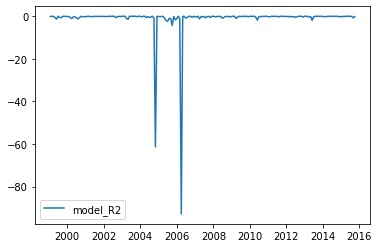

In [12]:
def describe_r2(model, predictors):
    r2_ts = pd.DataFrame(columns=['model_R2'], index=dates)

    for i in range(1,len(dates)-37):
        X_train, y_train, X_test, y_test = prepare_data(i, 36)
        X_train, X_test = X_train[predictors], X_test[predictors]

        try:
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            r2_ts['model_R2'].iloc[i] = r2_score(y_test, pred)

        except ValueError as err:
            print(err)

    fig, ax = plt.subplots()
    ax.plot(r2_ts)
    plt.legend(r2_ts.columns)
    print("Mean:  ", r2_ts.mean())
    print("Median:", np.median(r2_ts))

describe_r2(model=LinearRegression(), predictors=predictor_sets['FF3_*'])
